# TIL6010 - final assignment G.P. van Loon 5408393

For this assignment, I'm going to compare covid and mobility data on a provincial level in the Netherlands.
As a first step, I'm importing the necessary libraries.

In [28]:
import pandas as pd
from pathlib import Path
import numpy as np
import math
import scipy
from scipy.signal import find_peaks
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd

## Part I - Data import

First, I'm going to import and combine dataframes of the two types of data I found:
- Covid data from the RIVM on provincial level, giving cases, hospitalizations and casualties per day (absolute and cumulative)
- Mobility data from Google on provincial level, giving difference in trip numbers for several trip rates (percentage difference to baseline)

I'm starting off with the covid data.

In [2]:
# import the files for the covid data. I've chosen provincial data. Then eventually I can compare the number of cases, number of hospitalized patients and victims against the mobility patterns in provinces
file_path_covid = r'C:\Users\Govert\OneDrive - Delft University of Technology\Studie\Master jaar 2\Kwartiel 1\TIL6010 - TIL programming\til6010-assignments\Final assignment\RIVM_NL_provincial.csv'

df_covid = pd.read_csv(file_path_covid)

# again drop the unnecessary columns and change the column names to English and match the province column to the mobility dataframe
df_covid = df_covid[(df_covid['Provincienaam'].notna())]
df_covid.rename(columns =      {'Datum': 'date', 
                                'Provincienaam': 'province', 
                                'Provinciecode': 'province_code', 
                                'Type': 'type', 
                                'Aantal': 'number', 
                                'AantalCumulatief': 'number_cumulative'}, inplace=True)

# the covid dataframe has three rows for each data, with in every row either the number of cases, the victims or the number of hospitalized patients. I eventually want only one row per day, so I put everything in columns
df_covid['number of casualties'] = np.where(df_covid['type'] == 'Overleden', df_covid['number'], np.nan)
df_covid['number of hospitalized patients'] = np.where(df_covid['type'] == 'Ziekenhuisopname', df_covid['number'], np.nan)
df_covid['number of cases'] = np.where(df_covid['type'] == 'Totaal', df_covid['number'], np.nan)
df_covid['number of casualties_cum'] = np.where(df_covid['type'] == 'Overleden', df_covid['number_cumulative'], np.nan)
df_covid['number of hospitalized patients_cum'] = np.where(df_covid['type'] == 'Ziekenhuisopname', df_covid['number_cumulative'], np.nan)
df_covid['number of cases_cum'] = np.where(df_covid['type'] == 'Totaal', df_covid['number_cumulative'], np.nan)

# then I drop the old columns with the information in rows
df_covid = df_covid.drop(columns = ['province_code', 'type', 'number', 'number_cumulative'])

# I turn the dates to datetime
df_datetime_1 = pd.to_datetime(df_covid['date'],format='%d/%m/%Y')
df_covid['date'] = df_datetime_1

# Then I sort the columns again to make it clearer
df_covid = df_covid.sort_values(by=['province', 'date'], ascending=[True,True])
df_covid.reset_index(inplace=True)
df_covid = df_covid.drop(columns = ['index'])
df_covid.head(-10)


,date,province,number of casualties,number of hospitalized patients,number of cases,number of casualties_cum,number of hospitalized patients_cum,number of cases_cum
0,2020-02-27,Drenthe,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-27,Drenthe,NaN,NaN,NaN,NaN,NaN,0.0
2,2020-02-27,Drenthe,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-28,Drenthe,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-28,Drenthe,NaN,NaN,0.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
14925,2021-04-13,Zuid-Limburg,2.0,NaN,NaN,1533.0,NaN,NaN
14926,2021-04-13,Zuid-Limburg,NaN,NaN,562.0,NaN,NaN,90113.0
14927,2021-04-13,Zuid-Limburg,NaN,10.0,NaN,NaN,2405.0,NaN
14928,2021-04-14,Zuid-Limburg,4.0,NaN,NaN,1537.0,NaN,NaN


Then, I want to get rid of the fact that there are now three rows per date per province. I want to have only one row per date per province that has all information.

When I just resample over the dates, the information is forced into one row, but it ends up idential for all provinces. This is not wanted, so I try the following:
- I loop over all provinces to create new dataframes containing only the information for that specific province.
- Then I resample and add the result to the covid_final dataframe. 
- I also make a monthly dataframe that comes in handy at the end of the assignment.

This way I can resample without losing data. The resampling also gets rid of the provinces as those are strings, but I readd them as well.

In [3]:
# I create an empty dataframe with the same columns as the covid dataframe
rows = []
columns = []
df_covid_final = pd.DataFrame(rows, columns = df_covid.columns.values.tolist())
df_covid_month_final = pd.DataFrame(rows, columns = df_covid.columns.values.tolist())

# I create a list of the unique provinces in the covid dataframe to loop through
provinces = df_covid['province'].unique()

# I resample each province separately, because otherwise the all provinces end up with identical data
for province in provinces:
    df_province_1 = (df_covid.loc[df_covid['province'] == province])
    df_province_1_agg = (df_province_1.resample('7D',on='date').mean())
    df_province_1_agg.reset_index(inplace=True)
    df_province_1_agg['province'] = province
    df_covid_final = pd.concat((df_covid_final, df_province_1_agg))

# The monthly dataframe comes in handy later during the assignment
    df_province_1_aggmonth = (df_province_1.resample('M',on='date').sum())
    df_province_1_aggmonth.reset_index(inplace=True)
    df_province_1_aggmonth['province'] = province
    df_covid_month_final = pd.concat((df_covid_month_final,df_province_1_aggmonth))

df_covid_final.reset_index(inplace=True)
df_covid_month_final.reset_index(inplace=True)

df_covid_final.head(-10)

,index,date,province,number of casualties,number of hospitalized patients,number of cases,number of casualties_cum,number of hospitalized patients_cum,number of cases_cum
0,0,2020-02-27,Drenthe,NaN,NaN,0.333333,NaN,NaN,0.857143
1,1,2020-03-05,Drenthe,NaN,NaN,1.428571,NaN,NaN,7.285714
2,2,2020-03-12,Drenthe,0.000000,0.200000,1.428571,0.000000,0.500000,15.857143
3,3,2020-03-19,Drenthe,0.285714,1.857143,5.428571,1.428571,6.285714,43.714286
4,4,2020-03-26,Drenthe,0.428571,4.142857,11.714286,3.285714,28.285714,105.714286
...,...,...,...,...,...,...,...,...,...
705,45,2021-01-07,Zuid-Limburg,8.285714,6.857143,607.142857,1146.142857,2013.857143,53463.142857
706,46,2021-01-14,Zuid-Limburg,8.000000,5.857143,518.000000,1205.142857,2063.000000,57374.714286
707,47,2021-01-21,Zuid-Limburg,6.285714,4.571429,428.714286,1254.571429,2098.714286,60704.142857
708,48,2021-01-28,Zuid-Limburg,5.428571,4.428571,365.428571,1294.714286,2127.714286,63372.714286


Now, I'm importing the mobility data. The most noteworthy thing I do is changing the column names and reordering the columns.

In [4]:
# import the files for the mobility data
file_path_mobility_2020 = r'C:\Users\Govert\OneDrive - Delft University of Technology\Studie\Master jaar 2\Kwartiel 1\TIL6010 - TIL programming\til6010-assignments\Final assignment\2020_NL_Region_Mobility_report.csv'
file_path_mobility_2021 = r'C:\Users\Govert\OneDrive - Delft University of Technology\Studie\Master jaar 2\Kwartiel 1\TIL6010 - TIL programming\til6010-assignments\Final assignment\2021_NL_Region_Mobility_report.csv'

# open the files as dataframes
df_mob_2020 = pd.read_csv(file_path_mobility_2020)
df_mob_2021 = pd.read_csv(file_path_mobility_2021)

# combine the mobility dataframes and only leave the provincial data and drop all the unnecessary columns and rename most of the columns
df_mob_combined = pd.concat((df_mob_2020, df_mob_2021))
df_mobility = df_mob_combined[(df_mob_combined['sub_region_1'].notna()) & (df_mob_combined['sub_region_2'].isna())]
df_mobility = df_mobility.drop(columns = ['country_region_code', 'country_region', 'sub_region_2', 'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'])
df_mobility.rename(columns =    {'sub_region_1': 'province', 
                                'retail_and_recreation_percent_change_from_baseline': 'retail and recreation trips', 
                                'grocery_and_pharmacy_percent_change_from_baseline': 'grocery and pharmacy trips', 
                                'parks_percent_change_from_baseline': 'park trips',
                                'transit_stations_percent_change_from_baseline': 'transit station trips',
                                'workplaces_percent_change_from_baseline': 'work trips',
                                'residential_percent_change_from_baseline': 'residential trips'},inplace=True)

# set the date and reformat the dataframes
df_datetime_2 = pd.to_datetime(df_mobility['date'],format='%d/%m/%Y')
df_mobility['date'] = df_datetime_2
df_mobility = df_mobility.sort_values(by=['province','date'],ascending=[True,True])

# Reorder the columns
cols = list(df_mobility.columns.values)
df_mobility = df_mobility[[cols[1]] + [cols[0]]+ cols[2:8]]
df_mobility.head(-10)

,date,province,retail and recreation trips,grocery and pharmacy trips,park trips,transit station trips,work trips,residential trips
321,2020-02-15,Drenthe,-6.0,0.0,18.0,6.0,1.0,0.0
322,2020-02-16,Drenthe,-10.0,-10.0,-38.0,-12.0,-2.0,1.0
323,2020-02-17,Drenthe,3.0,-2.0,52.0,-24.0,-22.0,3.0
324,2020-02-18,Drenthe,8.0,0.0,45.0,-21.0,-22.0,3.0
325,2020-02-19,Drenthe,4.0,-4.0,49.0,-19.0,-22.0,2.0
...,...,...,...,...,...,...,...,...
26570,2021-08-27,Zuid-Limburg,6.0,13.0,148.0,-21.0,-37.0,5.0
26571,2021-08-28,Zuid-Limburg,-9.0,2.0,107.0,-5.0,4.0,1.0
26572,2021-08-29,Zuid-Limburg,-11.0,4.0,47.0,-6.0,11.0,1.0
26573,2021-08-30,Zuid-Limburg,25.0,18.0,162.0,-15.0,-34.0,5.0


Here I do something similar as I did with the covid data, but a bit different:
- I loop again over the provinces
- But I drop the first twelve days to make sure the dataframe begins at the same data as the covid data
- When I now resample, the dataframes are resampled to the same date. This is necessary for the merge I'm doing in the next code block
- Then I again add the provinces to the final dataframe
- The monthly dataframe is made again, for the end of the assignment

In [5]:
# Again I create an empty dataframe, this time with the columns of the mobility dataframe
rows = []
columns = []
df_mobility_final = pd.DataFrame(rows, columns = df_mobility.columns.values.tolist())
df_mobility_month_final = pd.DataFrame(rows, columns = df_mobility.columns.values.tolist())

# Again a list of all unique provinces
provinces = df_mobility['province'].unique()

# Then I loop through the provinces again, but this time I also drop the rows at the beginning until the date the covid dataframe starts. This way the mobility data is resampled to the same days/weeks as the covid data
for province in provinces:
    df_province_2 = (df_mobility.loc[df_mobility['province'] == province])
    df_province_2 = df_province_2.drop(df_province_2.index[0:12])
    df_province_2_agg = (df_province_2.resample('7D',on='date').mean())
    df_province_2_agg.reset_index(inplace=True)
    df_province_2_agg['province'] = province
    df_mobility_final = pd.concat((df_mobility_final, df_province_2_agg))

# The monthly dataframe comes in handy later during the assignment
    df_province_2_aggmonth = (df_province_2.resample('M',on='date').sum())
    df_province_2_aggmonth.reset_index(inplace=True)
    df_province_2_aggmonth['province'] = province
    df_mobility_month_final = pd.concat((df_mobility_month_final,df_province_2_aggmonth))

df_mobility_final.reset_index(inplace=True)
df_mobility_month_final.reset_index(inplace=True)

df_mobility_final.head(-10)

,index,date,province,retail and recreation trips,grocery and pharmacy trips,park trips,transit station trips,work trips,residential trips
0,0,2020-02-27,Drenthe,3.142857,2.714286,14.000000,1.285714,3.142857,0.428571
1,1,2020-03-05,Drenthe,2.142857,1.857143,10.857143,-0.857143,2.571429,0.285714
2,2,2020-03-12,Drenthe,-15.714286,11.571429,17.428571,-31.714286,-17.285714,7.428571
3,3,2020-03-19,Drenthe,-39.000000,-9.714286,14.285714,-54.571429,-37.428571,13.571429
4,4,2020-03-26,Drenthe,-43.714286,-18.714286,5.285714,-59.285714,-40.571429,14.571429
...,...,...,...,...,...,...,...,...,...
957,66,2021-06-03,Zuid-Limburg,2.285714,17.285714,177.428571,-15.714286,-8.285714,4.428571
958,67,2021-06-10,Zuid-Limburg,4.714286,18.285714,203.714286,-11.571429,-7.142857,2.857143
959,68,2021-06-17,Zuid-Limburg,-0.857143,14.428571,160.285714,-17.428571,-7.857143,3.714286
960,69,2021-06-24,Zuid-Limburg,5.285714,14.285714,168.142857,-13.571429,-8.571429,2.857143


Merging the dataframes then becomes relatively easily:
- I mention which columns to take from both dataframes
- I remove the old indices
- The monthly dataframe is also merged

In [6]:
# then I merge the covid and the mobility dataframes and drop the columns with the old indices
df_full = df_covid_final.merge(df_mobility_final, how='inner', left_on=['date','province'], right_on=['date','province'])
df_full = df_full.drop(columns=['index_x','index_y'])

# The monthly dataframe is also merged the same way
df_full_month = df_covid_month_final.merge(df_mobility_month_final,how='inner', left_on=['date','province'], right_on=['date','province'])
df_full_month = df_full_month.drop(columns=['index_x','index_y'])

df_full.head(-10)

,date,province,number of casualties,number of hospitalized patients,number of cases,number of casualties_cum,number of hospitalized patients_cum,number of cases_cum,retail and recreation trips,grocery and pharmacy trips,park trips,transit station trips,work trips,residential trips
0,2020-02-27,Drenthe,NaN,NaN,0.333333,NaN,NaN,0.857143,3.142857,2.714286,14.000000,1.285714,3.142857,0.428571
1,2020-03-05,Drenthe,NaN,NaN,1.428571,NaN,NaN,7.285714,2.142857,1.857143,10.857143,-0.857143,2.571429,0.285714
2,2020-03-12,Drenthe,0.000000,0.200000,1.428571,0.000000,0.500000,15.857143,-15.714286,11.571429,17.428571,-31.714286,-17.285714,7.428571
3,2020-03-19,Drenthe,0.285714,1.857143,5.428571,1.428571,6.285714,43.714286,-39.000000,-9.714286,14.285714,-54.571429,-37.428571,13.571429
4,2020-03-26,Drenthe,0.428571,4.142857,11.714286,3.285714,28.285714,105.714286,-43.714286,-18.714286,5.285714,-59.285714,-40.571429,14.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,2021-01-07,Zuid-Limburg,8.285714,6.857143,607.142857,1146.142857,2013.857143,53463.142857,-60.714286,-12.571429,-6.000000,-49.000000,-25.285714,12.142857
706,2021-01-14,Zuid-Limburg,8.000000,5.857143,518.000000,1205.142857,2063.000000,57374.714286,-61.857143,-15.285714,-9.571429,-50.142857,-27.000000,11.571429
707,2021-01-21,Zuid-Limburg,6.285714,4.571429,428.714286,1254.571429,2098.714286,60704.142857,-60.714286,-12.571429,3.714286,-48.285714,-26.571429,12.000000
708,2021-01-28,Zuid-Limburg,5.428571,4.428571,365.428571,1294.714286,2127.714286,63372.714286,-60.714286,-12.857143,-10.714286,-50.000000,-25.571429,12.142857


## Part II - Data processing

In the second part, I'm going to find common peaks for two kinds of trips and for two types of covid data. All for the province of Noord-Brabant.
- First, I would use my old find-my-peaks algorithm to define how to find the peaks and the valleys.
- Then, I would plot graphs of the peaks and valleys like in one of the previous assignments.

The peaks_dict is necessary to create a list of the peaks to plot. I will also include the dates_dict containing the dates of the peaks and valleys. 
I do this because I eventually want to be able to compare dates and not numbers. 

When I have the plots, I'm going to use code to look for common peaks and valleys as well. Just reading them from the graphs is too simple of course :)
- A margin is needed to also report peaks that differ 1 or 2 weeks, to be able to e.g. see the effect of higher covid deaths on number of trips
- This margin can easily be adapted by changing the weeks variables
- This margin is then turned into a range from 1 to that number of weeks
- I loop over the peaks of both the activity variables (trips or covid data)
- I loop over all the number in the margin range (so if weeks=3, I loop over 1, 2, and 3)
- In the loop, it is checked whether the two peaks are on the same date, or if peak A equals peak B if you add or distract the week number
- If one of those is the case, peak A is added to one of three lists: precise, before or after. These show whether peak B is either in the same week, in the margin before or in the margin after that week
- Then I print those dictionary lists in nicely formulated sentences that also change if the margin is adapted.

Additional information is also given in the comments in the code.

In [7]:
# In this block, all the variables can be adjusted. The defaults can be seen below. 
# The weeks variables are the margins for the common peak finding. 
activity_1 = 'work trips'
activity_2 = 'grocery and pharmacy trips'
activities_1 = [activity_1, activity_2]
weeks_1 = 1

activity_3 = 'number of hospitalized patients'
activity_4 = 'number of casualties'
activities_2 = [activity_3, activity_4]
weeks_2 = 1

province_1 = 'Noord-Brabant'

weeks_3 = 1

In [8]:
# first, I'm going to use my find_peaks function from assignment 2 to give the peaks in a list for each province for a specific activity
def my_find_peaks(data, activity, **kwargs):

    diff_1 = data[activity].diff(periods = -1)
    diff_2 = data[activity].diff(periods = 1)
    
    peaks = []
    for i in range(len(diff_1)):
        if diff_1[i] > 0 and diff_2[i] > 0:
            peaks.append(int(i))          
            
    return peaks

# And do the same for the valleys
def my_find_valleys(data, activity, **kwargs):

    diff_1 = data[activity].diff(periods = -1)
    diff_2 = data[activity].diff(periods = 1)

    valleys = []
    for i in range(len(diff_1)):
        if diff_1[i] < 0 and diff_2[i] < 0:
            valleys.append(int(i))          
            
    return valleys

In [9]:
# Then I start the fig_1ure and create several dictionaries that are necessary. The peaks and valleys dictionaries are for the graphs and the date dictionaries are for the next steps
fig_1 = go.Figure()
peaks_dict_1 = {}
valleys_dict_1 = {}
peaks_date_dict_1 = {}
valleys_date_dict_1 = {}

# I create a dataframe that contains only the data for the selected province and reset the indices for it
df_full_province_1 = (df_full.loc[df_full['province'] == province_1])
df_full_province_1.reset_index(inplace=True)

# I find the peaks and valleys and add them to the dictionaries
for activity in activities_1:
    max_ind = my_find_peaks(df_full_province_1, activity)
    peaks_dict_1[activity]=max_ind

    min_ind = my_find_valleys(df_full_province_1,activity)
    valleys_dict_1[activity]=min_ind
    
    # Then I turn them into dataframes to be able to use the dates for the graphs, and for the date dictionaries
    df_max_1 = df_full_province_1.iloc[max_ind]
    df_min_1 = df_full_province_1.iloc[min_ind]

    # The date dictionaries are filled with the dates of the peaks and the valleys
    peaks_date_dict_1[activity] = df_max_1['date']
    valleys_date_dict_1[activity] = df_min_1['date']
    
    # The graphs are formatted
    x1 = df_full_province_1['date']
    y1 = df_full_province_1[activity]
    x2 = df_max_1['date']
    y2 = df_max_1[activity]
    x3 = df_min_1['date']
    y3 = df_min_1[activity]
    fig_1.add_trace(go.Scatter(x=x1,y=y1,name=activity))
    fig_1.add_trace(go.Scatter(x=x2,y=y2,mode='markers',name='peaks ' + activity))
    fig_1.add_trace(go.Scatter(x=x3,y=y3,mode='markers',name='valleys ' + activity))

fig_1.update_layout(title= activity_1 + ' and ' + activity_2 + ' during covid times in ' + province_1)
fig_1.show()

In [10]:
# Now I'm going to compare the two date dictionaries and see if there are any common peaks
# The margin can be adapted by changing the number for the weeks_1 variable. The default is set to a margin of 1 week
margin_1 = list(range(1,weeks_1+1))

# A dictionary is made with the three lists for common peaks in the same week, peak B one week after peak A or peak B one week before peak A
common_peaks_1 = {}
common_peaks_1['in same week'] = []
common_peaks_1['in margin_1 after'] = []
common_peaks_1['in margin_1 before'] = []

# Then all the peaks are for-looped to add them to the right lists
for date1 in peaks_date_dict_1[activity_1]:
    for date2 in peaks_date_dict_1[activity_2]:
        for number in margin_1:
            if date1.date() == date2.date():
                common_peaks_1['in same week'].append(str(date1.date()))
            if date1.date() + datetime.timedelta(weeks=number) == date2.date():
                common_peaks_1['in margin_1 after'].append(str(date1.date()))
            if date1.date() - datetime.timedelta(weeks=number) == date2.date():
                common_peaks_1['in margin_1 before'].append(str(date1.date()))

# And then they are printed
print('Peaks for', activity_1, 'for which', activity_2, 'has a peak in the same week in', province_1, ':', common_peaks_1['in same week'])
print('Peaks for', activity_1, 'for which', activity_2, 'has a peak within', weeks_1, 'week(s) prior in', province_1, ':', common_peaks_1['in margin_1 before'])
print('Peaks for', activity_1, 'for which', activity_2, 'has a peak within', weeks_1, 'week(s) after in', province_1, ':', common_peaks_1['in margin_1 after'])

Peaks for work trips for which grocery and pharmacy trips has a peak in the same week in Noord-Brabant : ['2020-04-02', '2020-05-14', '2020-06-18', '2020-09-24', '2021-01-07']
Peaks for work trips for which grocery and pharmacy trips has a peak within 1 week(s) prior in Noord-Brabant : ['2020-08-27', '2020-10-29', '2020-12-03', '2021-01-28']
Peaks for work trips for which grocery and pharmacy trips has a peak within 1 week(s) after in Noord-Brabant : ['2020-03-05', '2020-04-16', '2021-03-18']


In [11]:
# Then I do the same for the valleys
common_valleys_1 = {}
common_valleys_1['in same week'] = []
common_valleys_1['in margin_1 after'] = []
common_valleys_1['in margin_1 before'] = []

for date1 in valleys_date_dict_1[activity_1]:
    for date2 in valleys_date_dict_1[activity_2]:
        for number in margin_1:
            if date1.date() == date2.date():
                common_valleys_1['in same week'].append(str(date1.date()))
            if date1.date() + datetime.timedelta(weeks=number) == date2.date():
                common_valleys_1['in margin_1 after'].append(str(date1.date()))
            if date1.date() - datetime.timedelta(weeks=number) == date2.date():
                common_valleys_1['in margin_1 before'].append(str(date1.date()))

print('Valleys for', activity_1, 'for which', activity_2, 'has a valley in the same week in', province_1, ':', common_valleys_1['in same week'])
print('Valleys for', activity_1, 'for which', activity_2, 'has a valley within', weeks_1, 'week(s) prior in', province_1, ':', common_valleys_1['in margin_1 before'])
print('Valleys for', activity_1, 'for which', activity_2, 'has a valley within', weeks_1, 'week(s) after in', province_1, ':', common_valleys_1['in margin_1 after'])

Valleys for work trips for which grocery and pharmacy trips has a valley in the same week in Noord-Brabant : ['2020-03-26', '2020-04-09', '2020-05-21', '2020-08-06', '2020-09-03', '2020-12-24', '2021-01-14', '2021-04-01']
Valleys for work trips for which grocery and pharmacy trips has a valley within 1 week(s) prior in Noord-Brabant : ['2020-10-15', '2020-11-05', '2021-02-04']
Valleys for work trips for which grocery and pharmacy trips has a valley within 1 week(s) after in Noord-Brabant : ['2020-04-23', '2020-10-01']


In [12]:
# And then the same is done for the covid data
fig_2 = go.Figure()
peaks_dict_2 = {}
valleys_dict_2 = {}
peaks_date_dict_2 = {}
valleys_date_dict_2 = {}
df_full_province_2 = (df_full.loc[df_full['province'] == province_1])
df_full_province_2.reset_index(inplace=True)

for activity in activities_2:
    max_ind = my_find_peaks(df_full_province_2, activity)
    peaks_dict_2[activity]=max_ind

    min_ind = my_find_valleys(df_full_province_2,activity)
    valleys_dict_2[activity]=min_ind
    
    df_max_2 = df_full_province_2.iloc[max_ind]
    df_min_2 = df_full_province_2.iloc[min_ind]
    peaks_date_dict_2[activity] = df_max_2['date']
    valleys_date_dict_2[activity] = df_min_2['date']
    
    x1 = df_full_province_2['date']
    y1 = df_full_province_2[activity]
    x2 = df_max_2['date']
    y2 = df_max_2[activity]
    x3 = df_min_2['date']
    y3 = df_min_2[activity]
    fig_2.add_trace(go.Scatter(x=x1,y=y1,name=activity))
    fig_2.add_trace(go.Scatter(x=x2,y=y2,mode='markers',name='peaks ' + activity))
    fig_2.add_trace(go.Scatter(x=x3,y=y3,mode='markers',name='valleys ' + activity))

fig_2.update_layout(title=activity_3 + ' and ' + activity_4 + ' because of covid in ' + province_1)
fig_2.show()

In [13]:
# Same as for mobility data
margin_2 = list(range(1,weeks_2+1))

common_peaks_2 = {}
common_peaks_2['in same week'] = []
common_peaks_2['in margin_2 after'] = []
common_peaks_2['in margin_2 before'] = []

for date3 in peaks_date_dict_2[activity_3]:
    for date4 in peaks_date_dict_2[activity_4]:
        for number in margin_2:
            if date3.date() == date4.date():
                common_peaks_2['in same week'].append(str(date3.date()))
            if date3.date() + datetime.timedelta(weeks=number) == date4.date():
                common_peaks_2['in margin_2 after'].append(str(date3.date()))
            if date3.date() - datetime.timedelta(weeks=number) == date4.date():
                common_peaks_2['in margin_2 before'].append(str(date3.date()))

print('Peaks for', activity_3, 'for which', activity_4, 'has a peak in the same week in', province, ':', common_peaks_2['in same week'])
print('Peaks for', activity_3, 'for which', activity_4, 'has a peak within', weeks_2, 'week(s) prior in', province, ':', common_peaks_2['in margin_2 before'])
print('Peaks for', activity_3, 'for which', activity_4, 'has a peak within', weeks_2, 'week(s) after in', province, ':', common_peaks_2['in margin_2 after'])

Peaks for number of hospitalized patients for which number of casualties has a peak in the same week in Zuid-Limburg : ['2020-03-26', '2020-05-28', '2020-12-17', '2021-01-07', '2021-04-08']
Peaks for number of hospitalized patients for which number of casualties has a peak within 1 week(s) prior in Zuid-Limburg : ['2020-04-23', '2020-11-12', '2021-02-18']
Peaks for number of hospitalized patients for which number of casualties has a peak within 1 week(s) after in Zuid-Limburg : ['2020-10-29']


In [14]:
# Same as for mobility data
common_valleys_2 = {}
common_valleys_2['in same week'] = []
common_valleys_2['in margin_2 after'] = []
common_valleys_2['in margin_2 before'] = []

for date3 in valleys_date_dict_2[activity_3]:
    for date4 in valleys_date_dict_2[activity_4]:
        for number in margin_2:
            if date3.date() == date4.date():
                common_valleys_2['in same week'].append(str(date3.date()))
            if date3.date() + datetime.timedelta(weeks=number) == date4.date():
                common_valleys_2['in margin_2 after'].append(str(date3.date()))
            if date3.date() - datetime.timedelta(weeks=number) == date4.date():
                common_valleys_2['in margin_2 before'].append(str(date3.date()))

print('Valleys for', activity_3, 'for which', activity_4, 'has a peak in the same week in', province, ':', common_valleys_2['in same week'])
print('Valleys for', activity_3, 'for which', activity_4, 'has a peak within', weeks_2, 'week(s) prior in', province, ':', common_valleys_2['in margin_2 before'])
print('Valleys for', activity_3, 'for which', activity_4, 'has a peak within', weeks_2, 'week(s) after in', province, ':', common_valleys_2['in margin_2 after'])

Valleys for number of hospitalized patients for which number of casualties has a peak in the same week in Zuid-Limburg : ['2020-05-21', '2020-07-09', '2020-09-10', '2021-03-04', '2021-04-01']
Valleys for number of hospitalized patients for which number of casualties has a peak within 1 week(s) prior in Zuid-Limburg : ['2020-04-16', '2020-11-26']
Valleys for number of hospitalized patients for which number of casualties has a peak within 1 week(s) after in Zuid-Limburg : ['2020-11-26', '2020-12-24']


Now I'm going to compare the mobility and the covid data

- As the units (percentages and absolute numbers) are very different, I don't first show a plot.
- As people tend to move less with higher cases/hospitalizations/casualties, I want to see common peaks for covid with valleys for mobility.
- Therefore, the only relationships that are printed are the common peaks and the peaks for the hospitalizations for which the trips had a valley after that peak. 

The logic is the same as for the previous questions. 

In [15]:
# The same as for the previous questions, but now with peaks for covid and valleys for mobility
margin_3 = list(range(1,weeks_3+1))

common_peaks_3 = {}
common_peaks_3['in same week'] = []
common_peaks_3['in margin_2 after'] = []

for date3 in peaks_date_dict_2[activity_3]:
    for date2 in valleys_date_dict_1[activity_2]:
        for number in margin_3:
            if date3.date() == date2.date():
                common_peaks_3['in same week'].append(str(date3.date()))
            if date3.date() + datetime.timedelta(weeks=number) == date2.date():
                common_peaks_3['in margin_2 after'].append(str(date3.date()))

print('Peaks in', activity_3, 'for which', activity_2, 'has a valley in the same week in', province, ':', common_peaks_3['in same week'])
print('Peaks in', activity_3, 'for which', activity_2, 'has a valley within', weeks_3, 'week(s) after in', province, ':', common_peaks_3['in margin_2 after'])

Peaks in number of hospitalized patients for which grocery and pharmacy trips has a valley in the same week in Zuid-Limburg : ['2020-03-26', '2020-10-29']
Peaks in number of hospitalized patients for which grocery and pharmacy trips has a valley within 1 week(s) after in Zuid-Limburg : ['2020-04-23', '2020-05-28', '2020-07-30', '2020-12-17', '2021-01-07', '2021-01-21', '2021-03-25']


As can be seen, there are quite some peaks in hospitalizations that are followed by peaks in trips. It could therefore be stated that the covid numbers actually affected transport behaviour in Noord Brabant.

Although I don't think it'll add much, I will show plots of the two activities below, also to verify the found results As mentioned, they are not in the same plot because of the different units.

In [16]:
# Two different graphs as the units are different, but in a subplot
fig_3 = make_subplots(rows=2,cols=1)

x1 = df_full_province_2['date']
y1 = df_full_province_2[activity_3]
x2 = df_max_2['date']
y2 = df_max_2[activity_3]
x3 = df_full_province_1['date']
y3 = df_full_province_1[activity_2]
x4 = df_min_1['date']
y4 = df_min_1[activity_2]

fig_3.append_trace(go.Scatter(x=x1,y=y1,name=activity_3),row=1,col=1)
fig_3.append_trace(go.Scatter(x=x2,y=y2,mode='markers',name='peaks ' + activity_3),row=1,col=1)
fig_3.append_trace(go.Scatter(x=x3,y=y3,name=activity_2),row=2,col=1)
fig_3.append_trace(go.Scatter(x=x4,y=y4,mode='markers',name='valleys ' + activity_2),row=2,col=1)

fig_3.update_layout(title='Covid and mobility data in ' + province_1)

fig_3.show()

## Part III - Data visualisation

For this last part, I'm going to tell check my personal experience on the covid narrative around the province of Noord-Brabant, by:
- Telling about my personal experiences on living in Eindhoven during the first covid wave in the second quarter of 2020
- Showing covid data on Brabant 
- Telling about the covid narrative around Noord-Brabant during the first wave and how this impacted my perspective on how people dealt with covid in their regions
- Comparing the number of cases in Noord-Brabant with the other provinces in a visual
- Comparing Noord-Brabant specifically to two other provinces
- Comparing how people reacted to covid in terms of mobility between these provinces
- Interpreting the results

First, I show my variables for this part. 

In [17]:
# Variables from previous part
activity_1 = 'work trips'
activity_2 = 'grocery and pharmacy trips'
activity_3 = 'number of hospitalized patients'
activity_4 = 'number of casualties'

province_1 = 'Noord-Brabant'

# New variable
activity_5 = 'number of cases'
activity_6 = 'retail and recreation trips'
activities_story_1 = [activity_3, activity_4, activity_5]
activities_story_2 = [activity_1, activity_2, activity_6]
activities_story_3 = [activity_5, activity_2]

province_2 = 'Noord-Holland'
province_3 = 'Zuid-Holland'
provinces_story = [province_1, province_2, province_3]

weeks_4 = 2

Then, I'm going to make a graph of the covid data of Noord-Brabant, just to explore the data and do some findings.

In [18]:
# First, I'll make a graph of all covid data on the province of Noord-Brabant
# I have to add the number of cases as a new activity and then I'm able to make the graph
fig_5 = go.Figure()

for activity in activities_story_1:
    x1 = df_full_province_2['date']
    y1 = df_full_province_2[activity]
    fig_5.add_trace(go.Scatter(x=x1,y=y1,name=activity))


fig_5.update_layout(title='covid in ' + province_1)
fig_5.show()

What is interesting is that the number of cases seems to be very low during the first wave, especially compared with the end of 2020 and the whole of 2021. This is the case, however, because the Netherlands only started up free CPR testing in June 2020. However, because of the lockdown and the nice weather the number of cases was very low by then. So when looking at the first wave, it's better to toggle off the number of cases and look at the number of hospitalized patients and number of casualties. 

- When you toggle off the number of cases, you can see however that there are quite some hospitalizations and casualties that occurred during the first wave
- This does show that there were quite some severe cases in the province and the toal number of cases probably was much higher
- The first covid case in the Netherlands was spotted in Tilburg, at the end of the carnaval week
- Many people thought this must have meant that many people had gotten covid over the course of Carnaval, and as we went into a strict lockdown relatively quickly after carnaval, this was probably the case
- The number of hospitalizations during March-May 2020 never would've been so high of only just a few people had gotten covid around the time of carnaval 2020. 

I moved to The Hague in July 2020, but before that I lived in Eindhoven. During the first wave from March-May 2020, I noticed the following things:
- The fact that the first covid case was spotted in Noord-Brabant, resulted in quite some judgmental reactions about the province
- The severity of the first wave in Noord-Brabant only contributed to this
- Me and my housemates in Eindhoven got quite some interesting comments on covid in Noord-Brabant from family members who were living in the Randstad
- I did notice that people in Eindhoven were following the covid rules very strictly, especially in terms of keeping distance both outside and inside

- When I went to the Randstad to visit familiy, however, I noticed that people were adhering to the rules a lot less
- This interested me, as I found that the number of cases didn't differ that much anymore between central provinces around the time of April-May
- It made me feel like people were thinking like Noord-Brabant was doing very badly in terms of covid, while their own provinces were also not doing that great
- So the narrative around covid numbers in Noord-Brabant just wasn't good

For this story, I want to check whether this feeling I had was rightfully there, or if Noord-Brabant was actually doing much worse than other provinces.

So let's make a bar chart showing the number of cases per province for every month.

In [19]:
# Making a bar chart that can be toggled for the months. Here the monthly dataframe created in the first part comes in handy!
# First a column is added to the df_month that only shows the year and the month
df_full_month['year_month'] = df_full_month['date'].dt.strftime('%Y-%m')

# Then the bar chart can be created using this column
fig_6 = px.bar(df_full_month, x= 'number of cases', y='province', orientation='h',color='province',
                animation_frame='year_month', animation_group='province')
fig_6.update_layout(showlegend=False,xaxis_range = [0,100])
fig_6.update_layout(yaxis={'categoryorder':'total ascending'})
fig_6.show()

By autoscaling the axes, the number of cases can also be seen in months with high numbers

This shows how the narrative around Noord-Brabant was not completely unfair in the beginning
- But it also shows that Zuid-Holland as of April 2020 had more cases than Noord-Brabant
- Nevertheless you heard many people talking about how bad Brabant was doing. but not about how bad a.o. Zuid-Holland was doing
- As an anecdote: my dad, who lives in Amsterdam, told me in May 2020 that I should watch out in Eindhoven with the number of cases there, even though the number had rapidly increased in Amsterdam/Noord-Holland to more cases per citizen than in Eindhoven
- It was interesting to see how the narrative around different provinces impacted the way people perceived the covid crisis in the Netherlands

To further illustrate this, let's add a geospatial map of the cumulative number of cases for each province at the latest date of the dataframe.

<AxesSubplot:title={'center':'Cumulative number of covid cases per province on the 4th of February 2021'}>

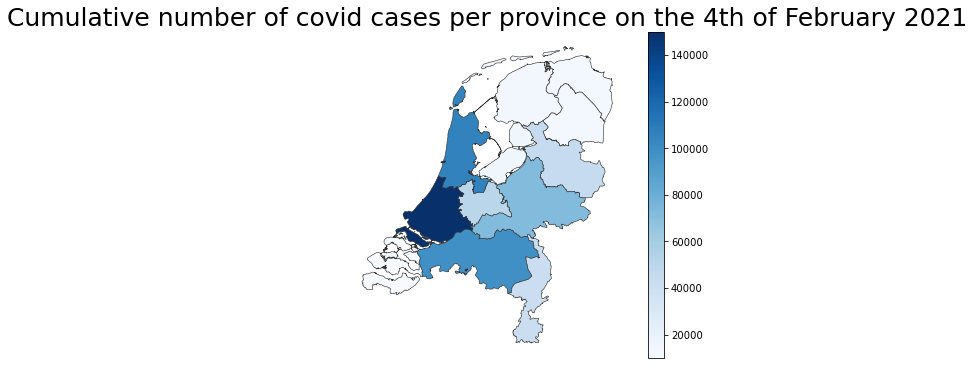

In [37]:
fp = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=1.1.0&typeName=cbsgebiedsindelingen:cbs_provincie_2021_gegeneraliseerd&outputFormat=json'
df_map = gpd.read_file(fp)
df_map['statnaam'] = df_map['statnaam'].replace(['Fryslân'],'Friesland')
df_map['statnaam'] = df_map['statnaam'].replace(['Limburg'],'Zuid-Limburg')

latest_date = '2021-02-04'
df_cumul = df_full.loc[df_full['date'] == latest_date]

merged = df_map.set_index('statnaam').join(df_cumul.set_index('province'))

activity_7 = 'number of cases_cum'
vmin, vmax = 10000,150000
fig, ax = plt.subplots(1,figsize=(8,6))
ax.axis('off')
ax.set_title('Cumulative number of covid cases per province on the 4th of February 2021', fontdict={'fontsize': '25', 'fontweight': '3'})

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.A = []
cbar = fig.colorbar(sm)

merged.plot(column=activity_7,cmap='Blues',linewidth=0.6,ax=ax,edgecolor='0.2')

Also here it can be seen that Noord-Brabant has not necessarily been the only province with a high number of cases.

Having observed this, let's add Noord-Holland and Zuid-Holland to the line graph a couple of blocks back.

In [20]:
# Making a line graph
fig_7 = go.Figure()

for province in provinces_story:
    df_province_story_1 = (df_full.loc[df_full['province'] == province])
    df_province_story_1.reset_index(inplace=True)

    for activity in activities_story_1:
        x1 = df_province_story_1['date']
        y1 = df_province_story_1[activity]
        fig_7.add_trace(go.Scatter(x=x1,y=y1,name=activity + ' ' + province))

fig_7.update_layout(title='covid data in ' + province_1 + ', ' + province_2 + ' and ' + province_3)
fig_7.show()

From this plot, it can be seen that Noord-Brabant for a short while had the most reported cases and hospitalizations, but the other two provinces quickly took over, especially Zuid-Holland. The narrative around Brabant being the worst province was thus not really fair, or at least only for April 2020.

As mentioned, another thing I experienced during covid is that this narrative around Noord-Brabant made people in Eindhoven adhere to the covid rules quite strictly
- When I went to the supermarket for example, everyone was very concise in keeping distance both outside and inside.
- However, when I was in Amsterdam a bit later on, people were barely keeping distance from me, both outside and inside. 
- This made me question whether people were also stricter in limiting trips in Noord-Brabant than in the other two provinces, despite having around the same number of cases etc.

Let's find out! We make a graph showing the trips for three trip purposes during the covid period.

In [21]:
# Making a line graph again
fig_8 = go.Figure()

for province in provinces_story:
    df_province_story_2 = (df_full.loc[df_full['province'] == province])
    df_province_story_2.reset_index(inplace=True)

    for activity in activities_story_2:
        x1 = df_province_story_2['date']
        y1 = df_province_story_2[activity]
        fig_8.add_trace(go.Scatter(x=x1,y=y1,name=activity + ' ' + province))

fig_8.update_layout(title='mobility during covid in ' + province_1 + ', ' + province_2 + ' and ' + province_3)
fig_8.show()

This plot shows some interesting findings. You can look at specific data by toggling. Clearly my personal, anecdotical, experience was not representative of the whole province. The province of Noord-Brabant shows to have the relatively highest number of trips for all three trip purposes over the covid period. It would be interesting to look into the differences between specific cities, as those might give off different results. For now, it is interesting to see that (although the differences are not huge) the citizens of Noord-Brabant seem to travel the most of these three provinces during the covid times despite the high number of cases. In the other two provinces, people have decreased their trips more because of covid. 

What would also be interesting, however, is to see if people from the three provinces reacted the same to peaks in the number of cases in their respective province. So if peaks in cases/hospitalizations resulted in fewer trips in the week(s) after. For Noord-Brabant, we have already seen this at the end of part II of this assignment. Let's put the results together for all three provinces.

In [22]:
# The same idea done in the second part, but now for multiple provinces at the same time
peaks_date_dict_3 = {}
valleys_date_dict_3 = {}

margin_4 = list(range(1,weeks_4+1))

common_peaks_4 = {}
common_peaks_4['in same week'] = []
common_peaks_4['in margin_2 after'] = []

# Here the for loop with the provinces is added
for province in provinces_story:
    df_province_story_3 = (df_full.loc[df_full['province'] == province])
    df_province_story_3.reset_index(inplace=True)
    for activity in activities_story_3:
        max_ind = my_find_peaks(df_province_story_3, activity)
        min_ind = my_find_valleys(df_province_story_3,activity)

        df_max_3 = df_province_story_3.iloc[max_ind]
        df_min_3 = df_province_story_3.iloc[min_ind]
        peaks_date_dict_3[activity] = df_max_3['date']
        valleys_date_dict_3[activity] = df_min_3['date']        

    for date5 in peaks_date_dict_3[activity_5]:
        for date2 in valleys_date_dict_3[activity_2]:
            for number in margin_4:
                if date5.date() == date2.date():
                    common_peaks_4['in same week'].append(str(date5.date()))
                if date5.date() + datetime.timedelta(weeks=number) == date2.date():
                    common_peaks_4['in margin_2 after'].append(str(date5.date()))

    unique_common_peaks_4 = {a:list(set(b)) for a, b in common_peaks_4.items()}

    print('Peaks in', activity_5, 'for which', activity_2, 'has a valley in the same week in', province, ':', unique_common_peaks_4['in same week'])
    print('Peaks in', activity_5, 'for which', activity_2, 'has a valley within', weeks_4, 'week(s) after in', province, ':', unique_common_peaks_4['in margin_2 after'])

Peaks in number of cases for which grocery and pharmacy trips has a valley in the same week in Noord-Brabant : ['2020-10-29', '2020-06-04', '2020-03-26', '2020-04-09', '2020-08-06']
Peaks in number of cases for which grocery and pharmacy trips has a valley within 2 week(s) after in Noord-Brabant : ['2020-12-17', '2020-11-19', '2020-03-26', '2020-08-20', '2021-03-25']
Peaks in number of cases for which grocery and pharmacy trips has a valley in the same week in Noord-Holland : ['2020-10-29', '2020-06-04', '2020-03-26', '2020-04-09', '2020-08-06']
Peaks in number of cases for which grocery and pharmacy trips has a valley within 2 week(s) after in Noord-Holland : ['2020-07-02', '2020-12-17', '2020-11-19', '2020-10-22', '2020-03-26', '2020-08-20', '2021-03-25', '2021-02-25']
Peaks in number of cases for which grocery and pharmacy trips has a valley in the same week in Zuid-Holland : ['2020-10-29', '2020-06-04', '2020-03-26', '2020-04-09', '2020-08-06']
Peaks in number of cases for which gr

This could be done for all of the trip purposes, but at least for grocery and pharmacy trips:
- It can be seen that people in Noord-Holland and Zuid-Holland reacted to the peaks in cases in terms of lowering trips more often than in Noord-Brabant
- It can also be seen that the provinces have precisely common peaks for cases and valleys for the trips at the same moments in time

All with all, it can be stated that:
- The citizens of Zuid-Holland rightfully decreased their number of trips during the covid crisis, as the number of cases there has often been the highest
- The citizens of Noord-Brabant decreased their number of trips the least of all three provinces, despite the fact that the number of cases has been relatively high there as well
- My personal experience was not representative for the whole province :)

It should be noted, however, that taking the provincial data does generalise quite different regions:
- These provinces consist of larger cities and countryside that have showed totally different numbers of cases and hospitalizations
- The composition of these provinces in terms of city-countryside is also different

Therefore, it would be good to look into the city data before coming to hard conclusions.